In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit

## Model Initialization & Configuration

In this section, we initialize the computational engine for the analysis. The core physics logic is encapsulated within the `EtaPrimeDecayModel` class (imported from `etap_eta_pipi_model_new.py`), ensuring a clean separation between the **production-grade model code** and this **research/analysis notebook**.

**Key Initialization Steps:**
* **Module Import:** Loads the custom library containing the Chiral Perturbation Theory ($\chi PT$) implementation, including the partial wave decomposition of the amplitude.
* **Dependency Injection:** We instantiate the model by passing the external data path (`Omnesfunctions...`). This triggers the internal `__init__` process, which parses the file and builds **cubic spline interpolators** for the Omnes functions (Real and Imaginary parts).
* **State Setup:** The instance `model` now holds all necessary physical constants and interpolation objects, as well as the decay_rate function, the dalitz_plot function and the $\chi^{2}$ function.

In [2]:
from etap_eta_pipi_model import EtaPrimeDecayModel

# Initialize the model (this runs __init__, loading the Omnes file)
model = EtaPrimeDecayModel("data/Omnesfunctions-d00-d10-central.dat")

2026-02-02 17:25:17,349 - etap_eta_pipi_model - INFO - Omnes functions loaded successfully.


In [3]:
print("Pre-computing integrals")
model.precompute_integrals()

2026-02-02 17:25:17,833 - etap_eta_pipi_model - INFO - Starting pre-computation of integrals...


Pre-computing integrals


2026-02-02 17:25:19,775 - etap_eta_pipi_model - INFO - Integration complete.


## Dalitz-Plot data from BESIII collaboration according to the paper https://arxiv.org/abs/1709.04627

In [4]:
data_BESIII = np.loadtxt("data/BESIII-2018-etap-to-pipieta-dalc.txt", skiprows=1)
data_BESIII.shape

(10794, 4)

In [5]:
data_BESIII_xc = data_BESIII[:,0]
data_BESIII_yc = data_BESIII[:,1]
data_BESIII_W = data_BESIII[:,2]
data_BESIII_eW = data_BESIII[:,3]

### $\chi^{2}$ Minimization Parameters

The model performs a simultaneous fit over three free parameters:

* **$A$ (Normalization):** The global normalization factor scaling the Dalitz plot probability density.
* **$L_{23}$ (Low-Energy Constant):** Represents the linear combination $3L_{2} + L_{3}$ from the Large-$N_c$ Chiral Perturbation Theory ($\chi$PT) amplitude.
* **$\alpha$ (Slope Parameter):** The coefficient for the linear polynomial multiplying the scalar $S$-wave amplitude. This accounts for:
    * Inelastic effects from $K\bar{K}$ intermediate states (Isospin $I=0$).
    * Contributions from left-hand cuts.

In [6]:
def objective_chisquared(params):
    return model.chisquared(params, data_BESIII_xc, data_BESIII_yc, data_BESIII_W, data_BESIII_eW)

# Manuell Minimization of $\chi^{2}$ with scipy.minimize

In [7]:
res = minimize(objective_chisquared, [0.002,0.001,-3.0], method="Nelder-Mead", bounds=[(None, None),(0.0, None),(None, None)])

In [8]:
print(f"Minimum χ²        = {res.fun:.6f}")
print(f"Best-fit params   = {res.x}")
print(f"χ² / dof          = {res.fun/(len(data_BESIII_W)+1-3):.3f}")

Minimum χ²        = 10863.347652
Best-fit params   = [ 2.85416416e-03  1.04426093e-03 -3.10901222e+00]
χ² / dof          = 1.007


# Constructing the hessian matrix $H$ and defining the covariance matrix as $\mathrm{COV}= 2\times H^{-1}$

In [9]:
hessian_matrix_inv = np.linalg.inv(model.compute_hessian(res.x, data_BESIII_xc, data_BESIII_yc, data_BESIII_W, data_BESIII_eW, 10**(-4)))
covariance_matrix = 2*hessian_matrix_inv

print(f"A = {2.85416416e-03:.3e} ± {np.sqrt(covariance_matrix[0,0]):.3e}")
print(f"L23 = {1.04426093e-03:.3e} ± {np.sqrt(covariance_matrix[1,1]):.3e}")
print(f"alpha = {-3.10901222:.3e} ± {np.sqrt(covariance_matrix[2,2]):.3e}")

A = 2.854e-03 ± 9.427e-05
L23 = 1.044e-03 ± 1.497e-05
alpha = -3.109e+00 ± 1.565e-02


# Computing the correlation matrix

In [10]:
variances = np.diag(covariance_matrix)

# 2. Compute standard deviations (errors)
sigmas = np.sqrt(variances)

# 3. Create the denominator matrix (outer product)
# This creates a matrix where element (i, j) is sigma_i * sigma_j
denominator = np.outer(sigmas, sigmas)

# 4. Divide element-wise
# Add a tiny epsilon or check for zero to avoid RuntimeWarning if an error is 0 (fixed param)
correlation_matrix = covariance_matrix / denominator
print(correlation_matrix)

[[ 1.         -0.979798   -0.16755127]
 [-0.979798    1.         -0.02491722]
 [-0.16755127 -0.02491722  1.        ]]


# Plotting a heat map for the correlation matrix

2026-02-02 17:25:25,097 - matplotlib.mathtext - INFO - Substituting symbol A from STIXNonUnicode
2026-02-02 17:25:25,158 - matplotlib.mathtext - INFO - Substituting symbol A from STIXNonUnicode


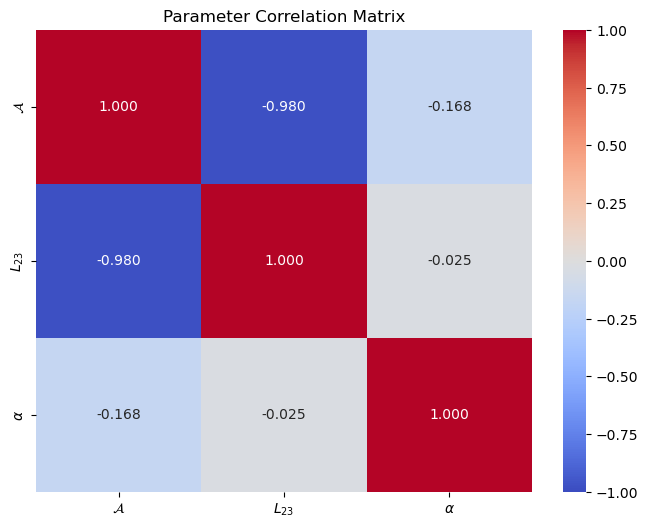

In [11]:
param_names = [r"$\mathcal{A}$", r"$L_{23}$", r"$\alpha$"]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True,      # Write the numbers in the boxes
            fmt=".3f",       # 3 decimal places
            cmap='coolwarm', # Red for +1, Blue for -1
            vmin=-1, vmax=1, # Fix scale
            xticklabels=param_names,
            yticklabels=param_names)
plt.title("Parameter Correlation Matrix")
plt.show()

# Plotting the 2D Residual Map for the Dalitz Plot Distribution

In [12]:
def plot_residual_map(x_bins, y_bins, z_data, z_err, z_theory):
    """
    Generates standard High Energy Physics goodness-of-fit plots.
    
    Parameters:
    x_bins, y_bins : Arrays of bin center coordinates (Dalitz variables)
    z_data         : Array of experimental values
    z_err          : Array of experimental errors (sigma)
    z_theory       : Array of theoretical values (from the fitted function)
    """
    
    # 1. Calculate Pulls (Standardized Residuals), masking out zero errors to avoid NaN
    mask = z_err > 0
    x_valid = x_bins[mask]
    y_valid = y_bins[mask]
    pulls = (z_data[mask] - z_theory[mask]) / z_err[mask]
    
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with color mapping
    sc = plt.scatter(x_valid, y_valid, c=pulls, cmap='coolwarm', 
                     vmin=-3, vmax=3, s=30, marker='s')
    
    plt.title("2D Residual Map (Goodness of Fit)", fontsize=14)
    plt.xlabel(r"$x$ (Dalitz var)", fontsize=12)
    plt.ylabel(r"$y$ (Dalitz var)", fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$(\mathrm{Data} - \mathrm{Theory}) / \sigma$", fontsize=12)
    
    plt.tight_layout()
    plt.show()

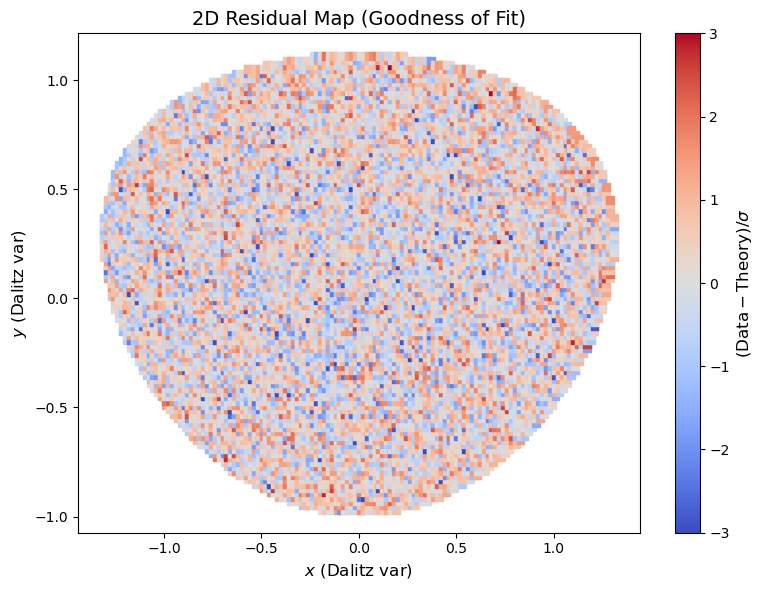

In [13]:
plot_residual_map(data_BESIII_xc, data_BESIII_yc, data_BESIII_W, data_BESIII_eW, model.dalitzplot_fit_function(data_BESIII_xc, data_BESIII_yc, res.x[0], res.x[1], res.x[2]))

# Plot the Distribution of the Residuals in a histogram

In [14]:
def plot_pull_distribution(z_data, z_err, z_theory):
    """
    Plots the histogram of pulls and compares it to a standard normal distribution.
    """
    # Calculate Pulls
    mask = z_err > 0
    pulls = (z_data[mask] - z_theory[mask]) / z_err[mask]
    
    plt.figure(figsize=(8, 6))
    
    # Plot histogram of pulls
    # density=True normalizes the area to 1
    n, bins, patches = plt.hist(pulls, bins=25, density=True, 
                                alpha=0.6, color='gray', label='Data Pulls')
    
    # Overlay Ideal Gaussian (Mean=0, Sigma=1)
    xmin, xmax = plt.xlim()
    x_axis = np.linspace(xmin, xmax, 100)
    plt.plot(x_axis, norm.pdf(x_axis, 0, 1), 'r--', lw=2, label='Ideal Gaussian (0, 1)')
    
    # Find mu and std of the pull distribution
    mu, std = norm.fit(pulls)
    
    plt.title(f"Pull Distribution\nMean={mu:.2f}, Std={std:.2f}", fontsize=14)
    plt.xlabel(r"Pull Value $(\mathrm{Data} - \mathrm{Theory}) / \sigma$", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

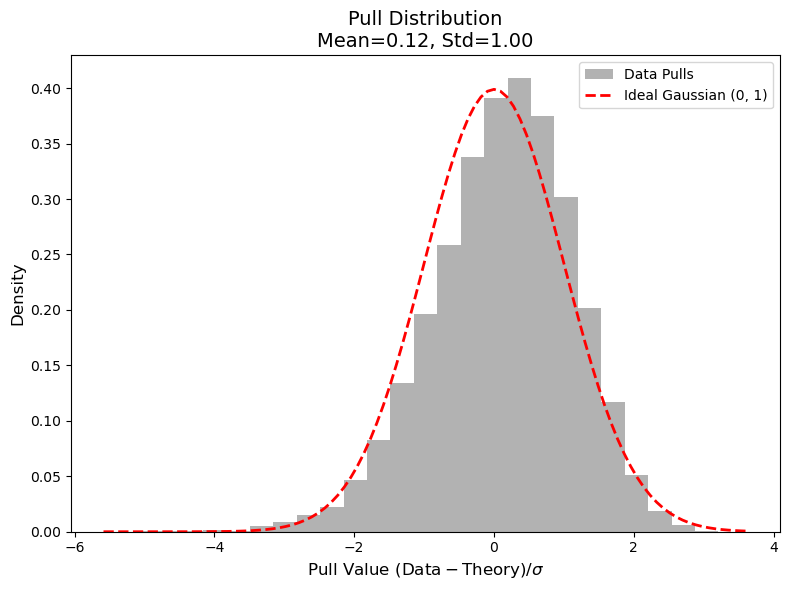

In [15]:
plot_pull_distribution(data_BESIII_W, data_BESIII_eW, model.dalitzplot_fit_function(data_BESIII_xc, data_BESIII_yc, res.x[0], res.x[1], res.x[2]))

# Performing the Fit again with the Package iminuit which is the Python frontend for the C++ MINUIT2 library

In [16]:
# ==============================================================================
# 3. THE TINY WRAPPER (The "Bridge")
# ==============================================================================
# This translates Minuit's (alpha, LEC, norm) -> Your function's ([...])
def fit_wrapper(A, L23, alpha):
    # Pack the separate variables into the list your function expects
    params_list = [A,L23,alpha]
    return model.chisquared(params_list, data_BESIII_xc, data_BESIII_yc, data_BESIII_W, data_BESIII_eW)

# ==============================================================================
# 4. RUNNING THE FIT
# ==============================================================================
m = Minuit(fit_wrapper, A=0.01, L23=0.001, alpha=-3.0)

m.errordef = Minuit.LEAST_SQUARES
m.limits["L23"] = (0.0, None)

print("Running MIGRAD minimization...")
m.migrad()

# D. Error Analysis
print("Running HESSE (Parabolic errors)...")
m.hesse()

print("Running MINOS (Asymmetric errors)")
m.minos()

# --- A. Symmetric Errors (Hesse) ---
print("Best values for Fit parameters:")
print(m.values)

# --- B. Symmetric Errors (Hesse) ---
print("Symmetric Errors (Hesse):")
print(m.errors)

# --- C. Asymmetric Errors (Minos) ---
print("\nAsymmetric Errors (Minos):")
print(m.merrors) 


# --- D. Covariance Matrix ---
print("\nCovariance Matrix:")
print(m.covariance)

# --- E. Correlation Matrix ---
print("\nCorrelation Matrix:")
print(m.covariance.correlation())

Running MIGRAD minimization...
Running HESSE (Parabolic errors)...
Running MINOS (Asymmetric errors)
Best values for Fit parameters:
<ValueView A=0.002854176392441887 L23=0.0010442482192044356 alpha=-3.1089755216510793>
Symmetric Errors (Hesse):
<ErrorView A=0.00010122175499148246 L23=1.6078565888091802e-05 alpha=0.015688754235596795>

Asymmetric Errors (Minos):
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           A           │          L23          │         alpha         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │ -0.09e-3  │  0.10e-3  │ -0.015e-3 │ 0.015e-3  │  -0.016   │   0.016   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   F